In [30]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

## Filtros

In [31]:
def filterImage (img):
    result = cv.GaussianBlur(img, (3,3), 0)

    plt.imshow(result)
    plt.title('Filtered')
    plt.show()
    return result 

## Border detection

In [32]:
def borderDetectionImage (img, k):
    sobel = cv.Sobel(img, cv.CV_8U, dx=0, dy=1, ksize=k)

    return sobel


In [33]:
def processFrame (frame):
    ## Converte frame para tons de cinza
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    gray_3 = cv.cvtColor(gray, cv.COLOR_GRAY2BGR)    

    ## Filtros
    filtered = filterImage(gray_3)

    ## Passa pela detecção de bordas
    borderDetection = borderDetectionImage(filtered, 3)

    ## Filtra com um treshold

    ## Passa pela detecção de curvas
    
    ## Exibe na saida saida
    # gray_3_channel = cv.cvtColor(borderDetection, cv.COLOR_GRAY2BGR)    
    # imgOutput = np.concatenate((frame, gray_3_channel), axis=1)
    # cv.imshow('VisaoComputacional', imgOutput)
    # cv.imshow('VisaoComputacional', filtered)

    plt.imshow(borderDetection)
    plt.title('my picture')
    plt.show()

le o video e cria janela:

In [34]:
path = r'./assets/birds_low.mp4'
video = cv.VideoCapture(path)

# cv.namedWindow('VisaoComputacional', cv.WINDOW_NORMAL)
# cv.resizeWindow('VisaoComputacional', 800,600)

Entra no loop principal, chama a função para processar a imagem

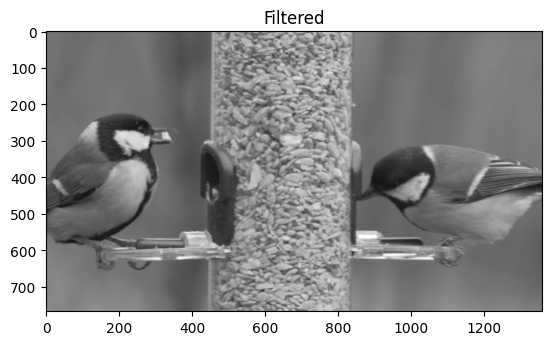

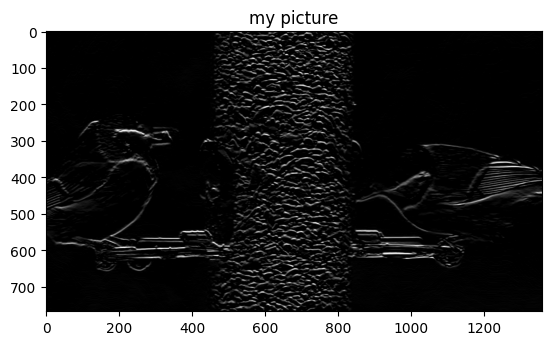

In [35]:
frame = cv.imread("./assets/birds_2.png")
processFrame(frame)

# while (video.isOpened()):
#     ret, frame = video.read()
#     if not ret:
#         print("Saindo ...")
#         break

#     ## Chama função para processar frame
#     processFrame(frame)
#     if cv.waitKey(1) == ord('q'):
#         break

# video.release()
# cv.destroyAllWindows()